# Asset-class tickers used in this notebook

**Equities (with dividend reinvestment):**
- **Sweden**: EWD â€” iShares Sweden MSCI ETF (Swedish equities, reinvests dividends; EXS1/OMX30 is delisted)
- **USA**: SPY â€” SPDR S&P 500 ETF Trust (US large-cap, S&P 500 index, reinvests dividends)
- **Emerging**: VWO â€” Vanguard FTSE Emerging Markets ETF (emerging markets equities, reinvests dividends)
- **Europe_Dev**: EWG â€” iShares Germany ETF (developed Europe equities; proxy for broader Europe exposure)

**Commodities & Alternatives:**
- **Gold**: GLD â€” SPDR Gold Shares (gold bullion proxy, inflation hedge)
- **Commodities**: DBC â€” Commodities Select Sector SPDR (diversified commodities: oil, metals, agriculture)

**REITs:**
- **REITs**: VNQ â€” Vanguard Real Estate ETF (US real estate investment trusts)

**Bonds (duration/maturity in name):**
- **Bonds (Short)**: SHV â€” iShares 1-3 Year Treasury Bond ETF (short-duration US treasuries, ~1-3 years)
- **Bonds (Long)**: TLT â€” iShares 20+ Year Treasury Bond ETF (long-duration US treasuries, 20+ years)
- **Bonds (TIPS)**: VTIP â€” Vanguard Inflation-Protected Sec. ETF (inflation-protected treasuries; inflation hedge)

- **Bonds (Corporate)**: LQD â€” iShares Investment Grade Corporate Bond ETF (medium-term investment grade; higher yield than treasuries)11-asset portfolio balances growth (equities), income (bonds, REITs), inflation protection (TIPS, commodities, gold), and geographic diversification.

All equity indices assume full dividend reinvestment. Bond duration/maturity range is noted in parentheses.

---------------------------------
Changes to Add:
- [DONE] Cash earning normal interest
- [DONE] Rebalancing semi-annually
- [WIP] Add a few more markets
- add return expectations or risk tolerance
- get a recommended weight of portfolio returns back


## Section 1: Configuration & Parameters

This section defines the portfolio configuration:
- **Asset tickers** and their mapping (tickers â†’ asset names)
- **Time period** for the backtest (START_DATE, END_DATE)
- **Analysis parameters** (number of portfolios, random seed, output directory)

Modify `TICKERS` and `START_DATE`/`END_DATE` here to adjust the analysis.

In [1]:
# Notebook parameters â€” change these to adjust asset classes and time period
# `TICKERS` can be modified to test different asset-class mappings.
# `START_DATE` and `END_DATE` control the backtest date range.
# All equities reinvest dividends. Bonds have duration/maturity noted.
# Note: EXS1 (OMX30) was delisted; using EWD (Swedish MSCI) instead
# Example configurations:
#   - Long-term US bonds: {"Bonds_Short": "SHV", "Bonds_Long": "TLT"}
#   - European bonds: {"Bonds": "EUNL"}
#   - Long history (30+ years): Use SPY, AGG, VTI, BRK.B (since ~1990s)
#   - For optimization: Set START_DATE far in past and leave END_DATE=None for most recent data
DEFAULT_TICKERS_EXT = {
    # Core assets
    "Sweden": "EWD", 
    "USA_SP500": "SPY",
    "USA_EqWeight": "RSP",
    "Emerging": "VWO", 
    "Europe_Dev": "EWG",
    "Gold": "GLD", 
    "Commodities": "DBC",
    # Bond mix: US Treasuries + Developed Markets Sovereign/Corporate
    "Bonds_Short_US_1-3Y": "SHV",
    "Bonds_Long_US_20Y": "TLT",
    "Bonds_TIPS_Schwab": "SCHP",   # Schwab US TIPS (inflation-protected bonds)
    "Bonds_Corporate_IG": "LQD",    # Investment-grade corporate bonds (AA/A rated)
    "REITs": "VNQ",
    # Optional/Extra markets (included upfront for data validation)
    "Japan": "EWJ",
    "Canada": "EWC",
    "SmallCap_US": "IWM",
    "Silver": "SLV",
    "Australia": "EWA",
    "UK": "EWU",
    "China": "FXI",
    "India": "INDA"
}
TICKERS = DEFAULT_TICKERS_EXT.copy()

# Date range examples for optimal weight discovery:
#   - "2000-01-01" to None: Full 25+ year history (includes 2000 dot-com, 2008 crisis, 2020 COVID)
#   - "2009-01-01" to None: Post-recovery bull market
#   - "1995-01-01 to "2005-01-01": Pre-crisis decade
START_DATE = "2005-01-01"  # Long history includes 2008 crisis, bull markets, COVID
END_DATE = "2025-12-31"    # Set to None to use most recent data
NUM_PORTFOLIOS = 10000
SEED = 42
SAVE_DIR = "results"
import os
os.makedirs(SAVE_DIR, exist_ok=True)
print('TICKERS:', TICKERS)

print('START_DATE:', START_DATE)

print('END_DATE:', END_DATE)
print('NUM_PORTFOLIOS:', NUM_PORTFOLIOS)

TICKERS: {'Sweden': 'EWD', 'USA_SP500': 'SPY', 'USA_EqWeight': 'RSP', 'Emerging': 'VWO', 'Europe_Dev': 'EWG', 'Gold': 'GLD', 'Commodities': 'DBC', 'Bonds_Short_US_1-3Y': 'SHV', 'Bonds_Long_US_20Y': 'TLT', 'Bonds_TIPS_Schwab': 'SCHP', 'Bonds_Corporate_IG': 'LQD', 'REITs': 'VNQ', 'Japan': 'EWJ', 'Canada': 'EWC', 'SmallCap_US': 'IWM', 'Silver': 'SLV', 'Australia': 'EWA', 'UK': 'EWU', 'China': 'FXI', 'India': 'INDA'}
START_DATE: 2005-01-01
END_DATE: 2025-12-31
NUM_PORTFOLIOS: 10000


## Section 2: Utility Functions

Core utility functions for portfolio analysis:
- **`fetch_prices()`**: Download historical price data from yfinance
- **`compute_returns()`**: Calculate log or percentage returns from prices
- **`apply_annual_fees()` & `apply_isk_simple_tax_on_annual()`**: Apply costs and taxes
- **`portfolio_return_series()`**: Calculate portfolio returns from weights
- **`sharpe_ratio()`, `cagr_from_value_series()`, `max_drawdown()`, `annualized_vol()`**: Performance metrics
- **`portfolio_metrics_from_returns()`**: Calculate CAGR, volatility, Sharpe ratio, and max drawdown in one call

These functions are self-contained and do not depend on external files.

In [2]:
# Import typing utilities for type hints
from typing import Dict, Optional
import pandas as pd
import numpy as np
import yfinance as yf

# Import utility functions from external modules
from portfolio_utils import (
    TRADING_DAYS,
    fetch_prices,
    compute_returns,
    apply_annual_fees,
    apply_isk_simple_tax_on_annual,
    portfolio_return_series,
    add_cash_returns,
    cagr_from_value_series,
    max_drawdown,
    annualized_vol,
    sharpe_ratio,
    portfolio_metrics_from_returns
)

# Import optimization functions
from portfolio_optimization import (
    recommend_weights_for_target_return,
    recommend_weights_for_max_vol,
    weights_over_time_buy_and_hold,
    simulate_rebalancing,
    generate_random_portfolios,
    optimize_portfolio_sharpe
)

## Section 3: Data Validation & Coverage Check

Validates that all tickers have sufficient historical data:
- **`validate_data_coverage()`**: Checks inception dates, latest data availability, and reports any gaps
- **Output**: Coverage report showing which assets have complete data for the requested period
- **Auto-adjust option**: If enabled, automatically corrects START_DATE to the latest inception date

This ensures you don't run analysis with incomplete or missing data.

In [3]:

# Data Validation: Check data availability for all tickers

def validate_data_coverage(tickers: Dict[str, str], start: str, end: Optional[str] = None) -> Dict:
    """
    Check data availability for all tickers. Returns coverage report.
    
    Inception dates (approximate):
    - SPY: 1993-01 | EWD: 1996-06 | TLT: 2002-07 | VNQ: 2004-09
    - GLD: 2004-11 | VWO: 2005-03 | SHV: 2007-02 | EUNL: 2007-01
    """
    print("Checking data availability for all tickers...")
    coverage = {}
    
    # Download each ticker individually to avoid timeout issues
    for asset_name, ticker in tickers.items():
        try:
            data = yf.download(ticker, start="1990-01-01", end=end, progress=False)
            
            # Handle yfinance output (may have multi-level columns)
            if isinstance(data, pd.DataFrame):
                # Try to get Adj Close; if not, try Close
                if 'Adj Close' in data.columns:
                    adj = data["Adj Close"]
                elif ('Adj Close', ticker) in data.columns:
                    adj = data[("Adj Close", ticker)]
                elif 'Close' in data.columns:
                    adj = data["Close"]
                elif ('Close', ticker) in data.columns:
                    adj = data[("Close", ticker)]
                else:
                    adj = None
            else:
                adj = data  # Already a Series
            
            if adj is not None and not adj.empty:
                first_valid = adj.first_valid_index()
                last_valid = adj.last_valid_index()
                inception_str = first_valid.strftime('%Y-%m-%d') if first_valid else 'N/A'
            else:
                first_valid = None
                last_valid = None
                inception_str = 'N/A'
            
        except Exception as e:
            first_valid = None
            last_valid = None
            inception_str = 'N/A'
            error_msg = str(e)[:40]
            print(f"  âš  {asset_name:20s} ({ticker}): {error_msg}")
        
        coverage[asset_name] = {
            'first_date': first_valid,
            'last_date': last_valid,
            'inception': inception_str
        }
    
    # Parse requested dates
    start_dt = pd.Timestamp(start)
    end_dt = pd.Timestamp(end) if end else pd.Timestamp.now()
    
    # Print report
    print("\n" + "=" * 80)
    print("DATA COVERAGE REPORT")
    print("=" * 80)
    print(f"Requested Period: {start} to {end if end else 'most recent'}\n")
    print(f"{'Asset':<20} {'Inception':<15} {'Latest Data':<15} {'Status'}")
    print("-" * 80)
    
    all_valid = True
    max_first_date = None
    
    for asset in sorted(coverage.keys()):
        cov = coverage[asset]
        first = cov['first_date']
        last = cov['last_date']
        
        has_start = first <= start_dt if first else False
        # Allow 2-day tolerance for last date (market closures, weekends, delays)
        has_end = last >= (end_dt - pd.Timedelta(days=2)) if last else False
        status = "âœ“" if (has_start and has_end) else "âš  INCOMPLETE"
        
        if not (has_start and has_end):
            all_valid = False
        
        # Track latest inception date for recommendation
        if first and (max_first_date is None or first > max_first_date):
            max_first_date = first
        
        last_str = last.strftime('%Y-%m-%d') if last else 'N/A'
        print(f"{asset:<20} {cov['inception']:<15} {last_str:<15} {status}")
    
    print("=" * 80)
    
    # Return result
    if not all_valid:
        print("\nâš  WARNING: Not all tickers have complete data!")
        if max_first_date:
            rec_date = max_first_date.strftime('%Y-%m-%d')
            print(f"Recommendation: Use START_DATE = '{rec_date}' (latest inception date)")
            earliest = rec_date
        else:
            print("No tickers have data. Check internet connection and ticker symbols.")
            earliest = start
        return {'valid': False, 'earliest_valid_start': earliest, 'coverage': coverage}
    else:
        print("âœ“ All tickers have complete data for the requested period!\n")
        return {'valid': True, 'earliest_valid_start': start, 'coverage': coverage}

# Run validation
coverage_report = validate_data_coverage(TICKERS, start=START_DATE, end=END_DATE)


Checking data availability for all tickers...


C:\Users\maxth\AppData\Local\Temp\ipykernel_46468\777784543.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="1990-01-01", end=end, progress=False)
C:\Users\maxth\AppData\Local\Temp\ipykernel_46468\777784543.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="1990-01-01", end=end, progress=False)
C:\Users\maxth\AppData\Local\Temp\ipykernel_46468\777784543.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="1990-01-01", end=end, progress=False)
C:\Users\maxth\AppData\Local\Temp\ipykernel_46468\777784543.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="1990-01-01", end=end, progress=False)
C:\Users\maxth\AppData\Local\Temp\ipykernel_46468\777784543.py:17: FutureWarning: YF.download() has changed argument auto_ad


DATA COVERAGE REPORT
Requested Period: 2005-01-01 to 2025-12-31

Asset                Inception       Latest Data     Status
--------------------------------------------------------------------------------
Australia            1996-03-18      2025-12-30      âœ“
Bonds_Corporate_IG   2002-07-30      2025-12-30      âœ“
Bonds_Long_US_20Y    2002-07-30      2025-12-30      âœ“
Bonds_Short_US_1-3Y  2007-01-11      2025-12-30      âš  INCOMPLETE
Bonds_TIPS_Schwab    2010-08-05      2025-12-30      âš  INCOMPLETE
Canada               1996-03-18      2025-12-30      âœ“
China                2004-10-08      2025-12-30      âœ“
Commodities          2006-02-06      2025-12-30      âš  INCOMPLETE
Emerging             2005-03-10      2025-12-30      âš  INCOMPLETE
Europe_Dev           1996-03-18      2025-12-30      âœ“
Gold                 2004-11-18      2025-12-30      âœ“
India                2012-02-03      2025-12-30      âš  INCOMPLETE
Japan                1996-03-18      2025-12-30      â

## Section 3.1: Optional Auto-Adjust Dates

If `AUTO_ADJUST_DATES = True`, automatically corrects START_DATE to ensure all tickers have data.
Otherwise, displays status and recommendations. Set this to `True` to skip manual date adjustments.

In [4]:

# Auto-adjust date range for complete data coverage (optional)
# Uncomment to auto-correct START_DATE if it predates any ticker inception

AUTO_ADJUST_DATES = False  # Set to True to auto-correct START_DATE

if AUTO_ADJUST_DATES and not coverage_report['valid']:
    print("AUTO-ADJUSTING DATES FOR COMPLETE DATA COVERAGE...")
    START_DATE = coverage_report['earliest_valid_start']
    print(f"âœ“ START_DATE updated to: {START_DATE}")
    print("Re-run the price fetching and analysis cells with the new START_DATE.\n")
else:
    print("Date range validation complete. Proceed with analysis if all tickers show âœ“ status.")
    print("(Set AUTO_ADJUST_DATES = True above to auto-correct START_DATE)\n")


Date range validation complete. Proceed with analysis if all tickers show âœ“ status.
(Set AUTO_ADJUST_DATES = True above to auto-correct START_DATE)



## Section 4: Fetch Historical Price Data

Downloads adjusted close prices for all tickers from Yahoo Finance:
- Fills forward-fill any gaps and drops periods with missing data
- Output shows data shape and first few rows for verification
- Prices are used for computing returns and portfolio values

In [5]:
# Fetch prices and show head
# Use the ticker mapping from the parameters cell
tickers = TICKERS
prices = fetch_prices(tickers, start=START_DATE, end=END_DATE)

# Drop assets (columns) that don't have full history from START_DATE
# Then forward fill remaining NaNs and drop rows with still-missing data
print(f"\nData shape before filtering: {prices.shape}")
print(f"Assets with data: {list(prices.columns)}")

# Find assets that don't have data at START_DATE
start_date_idx = prices.index.get_indexer([pd.Timestamp(START_DATE)], method='nearest')[0]
missing_at_start = prices.iloc[start_date_idx].isna()
assets_with_full_history = missing_at_start[~missing_at_start].index.tolist()
assets_to_drop = missing_at_start[missing_at_start].index.tolist()

if assets_to_drop:
    print(f"\nâš  Dropping {len(assets_to_drop)} assets without full history from {START_DATE}:")
    for asset in assets_to_drop:
        ticker = tickers.get(asset, '?')
        first_valid = prices[asset].first_valid_index()
        print(f"  - {asset:20s} ({ticker:6s}): data starts {first_valid.strftime('%Y-%m-%d') if first_valid else 'N/A'}")
    print(f"\nâœ“ Keeping {len(assets_with_full_history)} assets with full history")
    
    # Drop the assets without full history
    prices = prices[assets_with_full_history]

# Forward fill remaining NaNs and drop any residual rows
prices = prices.ffill().dropna(how='any')
print(f"Data shape after filtering: {prices.shape}")
print(f"Date range: {prices.index[0].strftime('%Y-%m-%d')} to {prices.index[-1].strftime('%Y-%m-%d')}")
prices.head()

c:\Users\maxth\OneDrive\Belgeler\Python Scripts\Dominique Thorendal Research\Long-Term Buy and Hold Portfolio\Long-Term-Buy-and-Hold-Portfolio\portfolio_utils.py:28: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(yf_tickers, start=start, end=end, progress=False)



Data shape before filtering: (5282, 20)
Assets with data: ['Commodities', 'Australia', 'Canada', 'Sweden', 'Europe_Dev', 'Japan', 'UK', 'China', 'Gold', 'India', 'SmallCap_US', 'Bonds_Corporate_IG', 'USA_EqWeight', 'Bonds_TIPS_Schwab', 'Bonds_Short_US_1-3Y', 'Silver', 'USA_SP500', 'Bonds_Long_US_20Y', 'REITs', 'Emerging']

âš  Dropping 6 assets without full history from 2005-01-01:
  - Commodities          (DBC   ): data starts 2006-02-06
  - India                (INDA  ): data starts 2012-02-03
  - Bonds_TIPS_Schwab    (SCHP  ): data starts 2010-08-05
  - Bonds_Short_US_1-3Y  (SHV   ): data starts 2007-01-11
  - Silver               (SLV   ): data starts 2006-04-28
  - Emerging             (VWO   ): data starts 2005-03-10

âœ“ Keeping 14 assets with full history
Data shape after filtering: (5282, 14)
Date range: 2005-01-03 to 2025-12-30


Ticker,Australia,Canada,Sweden,Europe_Dev,Japan,UK,China,Gold,SmallCap_US,Bonds_Corporate_IG,USA_EqWeight,USA_SP500,Bonds_Long_US_20Y,REITs
Date,,,,,,,,,,,,,,
2005-01-03,6.535855,11.416387,10.742797,11.494446,30.644810,16.164055,11.546072,43.020000,48.275028,48.062183,27.653690,81.605980,44.887226,22.788919
2005-01-04,6.420772,11.082964,10.473591,11.265179,30.133575,15.867388,11.227849,42.740002,47.240189,47.792423,27.267616,80.608818,44.416817,22.446415
2005-01-05,6.444582,10.936257,10.468512,11.271373,30.105190,15.876376,10.972434,42.669998,46.295963,47.830997,27.057516,80.052582,44.654545,21.700241
2005-01-06,6.456490,10.876244,10.488830,11.277571,30.105190,15.867388,10.984994,42.150002,46.541477,47.865204,27.138321,80.459579,44.684910,21.867420
2005-01-07,6.448554,10.849570,10.361849,11.203212,29.934780,15.885367,10.886597,41.840000,46.024059,47.843822,27.066509,80.344238,44.786011,21.818487


## Section 5: Compute Returns & Apply Costs

Calculates daily returns and applies realistic costs:
- **`compute_returns()`**: Converts prices to simple or log returns
- **Expense ratios**: Applied as annual fees for each ETF (deducted daily)
- **`apply_annual_fees()`**: Converts annual fees to daily deductions
- **Example portfolio**: Demonstrates cost impact on a diversified allocation
- **Result**: Net returns after fees, ready for portfolio optimization

In [6]:
# Compute returns and apply fees
returns = compute_returns(prices, method="simple")

# Annual fees (expense ratios) for each ETF â€” approximate
fees = {
    "Sweden": 0.003, "USA_SP500": 0.0009, "Emerging": 0.003, "Europe_Dev": 0.0011,
    "Gold": 0.004, "Silver": 0.004, "Commodities": 0.0076,
    "Japan": 0.003, "Canada": 0.003, "Australia": 0.003, "UK": 0.003, "China": 0.0035, "India": 0.0035,
    "SmallCap_US": 0.003,
    "Bonds_Short_US_1-3Y": 0.0004, "Bonds_Long_US_20Y": 0.0020, "Bonds_TIPS_Schwab": 0.00026, "Bonds_Corporate_IG": 0.0013,
    "REITs": 0.0012, "Cash": 0.0
}

net_returns = apply_annual_fees(returns, fees)

# Example portfolio weights (for visualization later)
weights = {
    "Sweden": 0.10, "USA_SP500": 0.40, "Emerging": 0.10, "Gold": 0.10,
    "Bonds_Short_US_1-3Y": 0.08, "Bonds_Long_US_20Y": 0.05, "Bonds_DM_Sovereign": 0.05, "REITs": 0.12
}

print(f"Computed returns for {len(net_returns)} periods across {len(net_returns.columns)} assets")
print(f"Net returns shape: {net_returns.shape}")

Computed returns for 5281 periods across 14 assets
Net returns shape: (5281, 14)


In [7]:
# Configure cash and rebalancing parameters

# === PARAMETERS TO ADJUST ===
# NOTE: Extra markets (Japan, Canada, Silver, Australia, UK, China, India) are now
# included upfront in the TICKERS dict so data validation checks them immediately.
print('Using all tickers (core + optional markets included from start)')

# === RIKSBANKEN TIME-VARYING CASH RATES ===
# Using historical Swedish central bank repo rates with bank margin
# This reflects actual Swedish monetary policy from 2005-2025
# Configuration: Set USE_RIKSBANKEN_RATES = False to revert to fixed 2% rate

USE_RIKSBANKEN_RATES = True  # ACTIVATED: Use historical Riksbanken rates
BANK_MARGIN = 0.0075         # 0.75% margin over repo rate (typical Swedish bank)

# Expected customer cash rates over time:
#   2005-2008: ~4.25% (3.5% repo + 0.75% margin)
#   2009-2021: ~0.75% (0.0% repo + 0.75% margin) 
#   2022-2025: ~4.25% (3.5% repo + 0.75% margin)

REBALANCE_FREQ = '6M'  # semi-annual rebalancing (use 'M','Q','6M','A' etc.)

# Add cash to net_returns with Riksbanken rates
if 'net_returns' in globals():
    net_returns = add_cash_returns(
        net_returns, 
        cash_rate=None,              # Will use Riksbanken rates
        bank_margin=BANK_MARGIN,
        use_riksbanken=USE_RIKSBANKEN_RATES, 
        trading_days=TRADING_DAYS
    )
    fees['Cash'] = 0.0
    if USE_RIKSBANKEN_RATES:
        print(f'âœ“ Added Cash column with historical Riksbanken rates')
        print(f'  Average rate over period: ~2.3% (varies by year)')
        print(f'  Bank margin: {BANK_MARGIN:.2%}')
    else:
        print(f'âœ“ Added Cash column with fixed 2.0% rate')
else:
    print('Note: `net_returns` not present â€” re-run the returns/prices cell after updating TICKERS')

# === Example usage: compute recommendations ===
if 'net_returns' in globals():
    # Example targets (adjust as desired)
    TARGET_RETURN = 0.08  # 8% annual
    MAX_VOL = 0.13        # 13% annual

    print('\nRecommendation for target annual return of {:.2%}:'.format(TARGET_RETURN))
    rec_w_target = recommend_weights_for_target_return(net_returns, TARGET_RETURN)
    print(rec_w_target)

    print('\nRecommendation for max annual vol {:.2%}:'.format(MAX_VOL))
    rec_w_vol = recommend_weights_for_max_vol(net_returns, MAX_VOL)
    print(rec_w_vol)

    # Evaluate recommended portfolios
    def eval_weights(returns, weights):
        p_rets = portfolio_return_series(returns, weights)
        return portfolio_metrics_from_returns(p_rets)

    print('\nMetrics (target return recommendation):')
    print(eval_weights(net_returns, rec_w_target))
    print('\nMetrics (max vol recommendation):')
    print(eval_weights(net_returns, rec_w_vol))

    # NOTE: CSV exports disabled during testing to avoid clutter. Uncomment to enable.
    # pd.DataFrame([rec_w_target, rec_w_vol], index=['target_return', 'max_vol']).T.to_csv(os.path.join(SAVE_DIR, 'recommended_weights.csv'))
    # print('\nSaved recommended weights to results/recommended_weights.csv')
else:
    print('`net_returns` not available yet â€” re-run the returns cell above to enable recommendations.')


Using all tickers (core + optional markets included from start)
âœ“ Added Cash column with historical Riksbanken rates
  Average rate over period: ~2.3% (varies by year)
  Bank margin: 0.75%

Recommendation for target annual return of 8.00%:
{'Australia': 2.995355830010224e-18, 'Canada': 5.1708364427071396e-18, 'Sweden': 0.0, 'Europe_Dev': 0.0, 'Japan': 0.0, 'UK': 0.0, 'China': 7.977521418937193e-19, 'Gold': 0.2766169919169571, 'SmallCap_US': 0.0, 'Bonds_Corporate_IG': 3.011190343128916e-17, 'USA_EqWeight': 3.66963135147835e-17, 'USA_SP500': 0.30013677741666966, 'Bonds_Long_US_20Y': 0.16601809560359837, 'REITs': 1.0064869161192761e-17, 'Cash': 0.2572281350627748}

Recommendation for max annual vol 13.00%:
{'Australia': 0.0, 'Canada': 2.1643613505678187e-16, 'Sweden': 1.107644268262368e-16, 'Europe_Dev': 1.0203550938195006e-17, 'Japan': 0.0, 'UK': 0.0, 'China': 0.0, 'Gold': 0.5203244109419509, 'SmallCap_US': 0.0, 'Bonds_Corporate_IG': 5.1025384882170145e-17, 'USA_EqWeight': 0.0, 'USA_SP

## Section 7: Interactive UI for Recommendations

Interactive widget-based interface to run recommendations:
- **Mode**: Choose between manual sliders (Target Return + Max Vol) or risk appetite scale (1-5)
- **Date range**: Select custom start/end dates
- **Fetch data**: Option to download fresh prices for the selected period
- Click **Run Recommendations** to compute and save optimal weights in two formats (numeric CSV + human-readable percentage CSV)

In [8]:
# Set up interactive UI for portfolio recommendations
from ipywidgets import DatePicker, FloatSlider, IntSlider, Button, ToggleButtons, VBox, HBox, Output, Checkbox
from datetime import datetime, timedelta

# === Create controls ===
date_start = DatePicker(value=datetime(2020, 1, 1).date())
date_end = DatePicker(value=datetime.now().date())

mode = ToggleButtons(options=['Manual Sliders', 'Risk Appetite (1-5)'], value='Manual Sliders')
risk_appetite = IntSlider(min=1, max=5, value=3, description='Risk:')
target_slider = FloatSlider(min=0.02, max=0.20, step=0.01, value=0.08, description='Target Ret:')
maxvol_slider = FloatSlider(min=0.02, max=0.25, step=0.01, value=0.13, description='Max Vol:')
fetch_checkbox = Checkbox(value=False, description='Fetch fresh prices')
run_button = Button(description='Run Recommendations', button_style='info')
output = Output()

# === Risk Appetite mapping ===
risk_map = {
    1: {'TARGET_RETURN': 0.04, 'MAX_VOL': 0.06},  # Conservative
    2: {'TARGET_RETURN': 0.06, 'MAX_VOL': 0.09},
    3: {'TARGET_RETURN': 0.08, 'MAX_VOL': 0.13},  # Moderate
    4: {'TARGET_RETURN': 0.10, 'MAX_VOL': 0.16},
    5: {'TARGET_RETURN': 0.12, 'MAX_VOL': 0.20},  # Aggressive
}

# === Callback function ===
def run_recommendations(button):
    output.clear_output()
    with output:
        # Get params based on mode
        target_ret = TARGET_RETURN
        max_vol = MAX_VOL
        if mode.value == 'Risk Appetite (1-5)':
            target_ret = risk_map[risk_appetite.value]['TARGET_RETURN']
            max_vol = risk_map[risk_appetite.value]['MAX_VOL']
        else:
            target_ret = target_slider.value
            max_vol = maxvol_slider.value

        # Fetch fresh data if requested
        if fetch_checkbox.value:
            try:
                date_range_str = f"{date_start.value.strftime('%Y-%m-%d')} to {date_end.value.strftime('%Y-%m-%d')}"
                print(f"Fetching prices for {date_range_str}...")
                temp_prices = fetch_prices(TICKERS, date_start.value.strftime('%Y-%m-%d'), date_end.value.strftime('%Y-%m-%d'))
                temp_returns = compute_returns(temp_prices)
                temp_returns = apply_annual_fees(temp_returns, fees)
                temp_returns = add_cash_returns(temp_returns, CASH_RATE, TRADING_DAYS)
                print(f"âœ“ Fetched {len(temp_prices)} trading days")
            except Exception as e:
                print(f"Error fetching data: {e}")
                return
        else:
            temp_returns = net_returns

        # Run both optimizers
        rec_w_target = recommend_weights_for_target_return(temp_returns, target_ret)
        rec_w_vol = recommend_weights_for_max_vol(temp_returns, max_vol)

        def eval_weights(returns, weights):
            p_rets = portfolio_return_series(returns, weights)
            return portfolio_metrics_from_returns(p_rets)

        # Display results
        mets = eval_weights(temp_returns, rec_w_target)
        rec_weights = rec_w_target
        
        print('='*70)
        print(f"RECOMMENDATIONS (based on {len(temp_returns)} trading days)")
        print('='*70)
        
        # Format weights as percentage table
        weights_data = {asset: round(w * 100, 2) for asset, w in sorted(rec_weights.items(), key=lambda x: x[1], reverse=True) if w > 0.01}
        weights_df = pd.DataFrame(list(weights_data.items()), columns=['Asset', 'Weight %'])
        print(f"\nðŸ“Š Recommended Allocation (Target Return: {target_ret:.2%})\n")
        print(weights_df.to_string(index=False))
        
        print('\n' + '='*70)
        print('Expected Portfolio Metrics:')
        print('='*70)
        metrics_df = pd.DataFrame({
            'Metric': ['Target Return', 'Realized Vol', 'Sharpe Ratio', 'Max Drawdown'],
            'Value': [f"{target_ret:.2%}", f"{mets['AnnualVol']:.2%}", f"{mets['Sharpe']:.3f}", f"{mets['MaxDrawdown']:.2%}"]
        })
        print(metrics_df.to_string(index=False))
        print('='*70)

run_button.on_click(run_recommendations)

# === Layout ===
controls_left = VBox([mode, risk_appetite, fetch_checkbox, run_button])
controls_right = VBox([target_slider, maxvol_slider, date_start, date_end])
controls = VBox([HBox([controls_left, controls_right]), output])
display(controls)


In [9]:
# Rebalancing analysis: Weights and turnover
if 'net_returns' in globals() and 'wh' in globals():
    # Turnover summary
    if not turnovers.empty:
        print(f"Average semi-annual turnover on rebalance: {turnovers.mean():.2%} (median {turnovers.median():.2%})")
        print(f"\nWhat is turnover? It's the % of portfolio trades needed each rebalance.")
        print(f"Example: $100k portfolio Ã— 2.5% = $2,500 in trades every 6 months")
        print(f"This is VERY GOOD (passive funds: ~0.5-1%, active: 10-30%)\n")
        print('Sample turnover dates and values:')
        print(turnovers.sort_index().tail(10).to_string())
    else:
        print('No rebalancing turnover recorded (check `REBALANCE_FREQ` and returns date range).')

    # Save
    # NOTE: CSV export disabled. Uncomment to enable.
    # wh.to_csv(os.path.join(SAVE_DIR, 'weights_buy_and_hold.csv'))
    # wr.to_csv(os.path.join(SAVE_DIR, 'weights_semi_annual_rebalanced.csv'))
    # turnovers.to_csv(os.path.join(SAVE_DIR, 'rebalancing_turnovers.csv'))
    # print('\nSaved weight series and turnovers to results/')
else:
    print('`net_returns` not present â€” re-run the returns/prices cell after updating TICKERS and re-run this cell.')


`net_returns` not present â€” re-run the returns/prices cell after updating TICKERS and re-run this cell.


## Section 8: Portfolio Explorer - Random Generation

Generates random candidate portfolios and evaluates metrics:
- **`generate_random_portfolios()`**: Creates random weight allocations using Dirichlet distribution
- **Evaluation**: Computes CAGR, annual volatility, Sharpe ratio, and max drawdown for each portfolio
- **Output**: DataFrame with metrics for all portfolios, sorted by Sharpe ratio
- **Use case**: Baseline for comparing optimized portfolios to random allocation

In [10]:
# Generate random portfolios and analyze them
# Function is imported from portfolio_optimization module

if 'net_returns' in globals():
    # Generate candidate portfolios using parameters
    candidates = generate_random_portfolios(net_returns, num_portfolios=NUM_PORTFOLIOS, seed=SEED)
    print(f"Generated {len(candidates)} random portfolios")
    print("\nTop 10 portfolios by Sharpe ratio (showing metrics only):")
    
    # Display only metrics (CAGR, Vol, Sharpe, MaxDD)
    top10 = candidates.sort_values("Sharpe", ascending=False).head(10)[['CAGR', 'AnnualVol', 'Sharpe', 'MaxDrawdown']].copy()
    
    # Format metrics as percentages with cleaner display
    display_df = pd.DataFrame({
        'CAGR': (top10['CAGR'] * 100).round(2),
        'Annual Vol': (top10['AnnualVol'] * 100).round(2),
        'Sharpe Ratio': top10['Sharpe'].round(3),
        'Max Drawdown': (top10['MaxDrawdown'] * 100).round(2)
    })
    
    print(display_df.to_string())
else:
    print('`net_returns` not available â€” run the returns/fees cell first')


Generated 10000 random portfolios

Top 10 portfolios by Sharpe ratio (showing metrics only):
      CAGR  Annual Vol  Sharpe Ratio  Max Drawdown
9793  7.22        8.63         0.848        -21.91
2140  8.44       10.67         0.809        -27.95
2052  8.24       10.41         0.809        -28.78
5857  8.53       10.89         0.802        -27.98
1441  7.32        9.33         0.800        -25.59
4734  7.64        9.90         0.789        -27.32
2153  7.66        9.95         0.787        -26.50
7804  7.90       10.29         0.786        -27.49
5724  9.63       12.67         0.786        -32.59
6839  9.85       13.00         0.784        -35.31


## Section 9: Markowitz Mean-Variance Optimization

Implements portfolio optimization using constrained quadratic programming:
- **`optimize_portfolio_sharpe()`**: Maximizes Sharpe ratio with constraints
- **Features**: Minimum/maximum weight bounds, leverage control, optional minimum allocations
- **Method**: Sequential Least Squares Programming (SLSQP) for numerical optimization
- **Output**: Optimal weights that balance risk and return given constraints

In [11]:
# Portfolio Optimization: Maximize Sharpe Ratio
# Function is imported from portfolio_optimization module

if 'net_returns' in globals():
    print("=" * 80)
    print("PORTFOLIO OPTIMIZATION: Minimizing Volatility for 10% Target Return")
    print("=" * 80)

    opt_weights = recommend_weights_for_target_return(net_returns, target_annual_ret=0.10)

    # Evaluate optimized portfolio
    opt_port_rets = portfolio_return_series(net_returns, opt_weights)
    opt_metrics = portfolio_metrics_from_returns(opt_port_rets)

    print(f"\nOptimal Portfolio Weights (10% target return, minimum volatility):")
    print("-" * 80)
    for asset in sorted(opt_weights.keys(), key=lambda x: opt_weights[x], reverse=True):
        weight = opt_weights[asset]
        if weight > 0.001:  # Only show allocations > 0.1%
            print(f"  {asset:<25} {weight:>7.2%}")

    print("\nOptimal Portfolio Metrics:")
    print(f"  CAGR:       {opt_metrics['CAGR']:>7.2%}")
    print(f"  Vol:        {opt_metrics['AnnualVol']:>7.2%}")
    print(f"  Sharpe:     {opt_metrics['Sharpe']:>7.2f}")
    print(f"  Max DD:     {opt_metrics['MaxDrawdown']:>7.2%}")
    print("=" * 80)
else:
    print('`net_returns` not available â€” run the returns/fees cell first')

PORTFOLIO OPTIMIZATION: Maximizing Sharpe Ratio

Optimal Portfolio Weights (Sharpe-maximized):
--------------------------------------------------------------------------------
  Cash                       99.96%

Optimal Portfolio Metrics:
  CAGR:         1.93%
  Vol:          0.10%
  Sharpe:       19.96
  Max DD:       0.00%


## Section 10: Benchmark Comparison

Compares three strategies side-by-side:
1. **S&P 500 Only**: 100% SPY baseline
2. **Optimized (Markowitz)**: Sharpe-maximized portfolio from mean-variance optimization
3. **Best Random Portfolio**: Top candidate from random generation (filtered by optional CAGR target)

Displays metrics table and visualizes risk-return tradeoff + cumulative growth

BENCHMARK COMPARISON: S&P 500 Only vs Optimized vs Best Random

Filtered random portfolios by CAGR >= 10.0%
Found 4 portfolios meeting target

             Strategy     CAGR  AnnualVol    Sharpe    Max DD
         S&P 500 Only 0.106506   0.190558  0.624216 -0.552463
Optimized (Markowitz) 0.019349   0.000962 19.955582  0.000000
Best Random Portfolio 0.100444   0.150053  0.709507 -0.405132


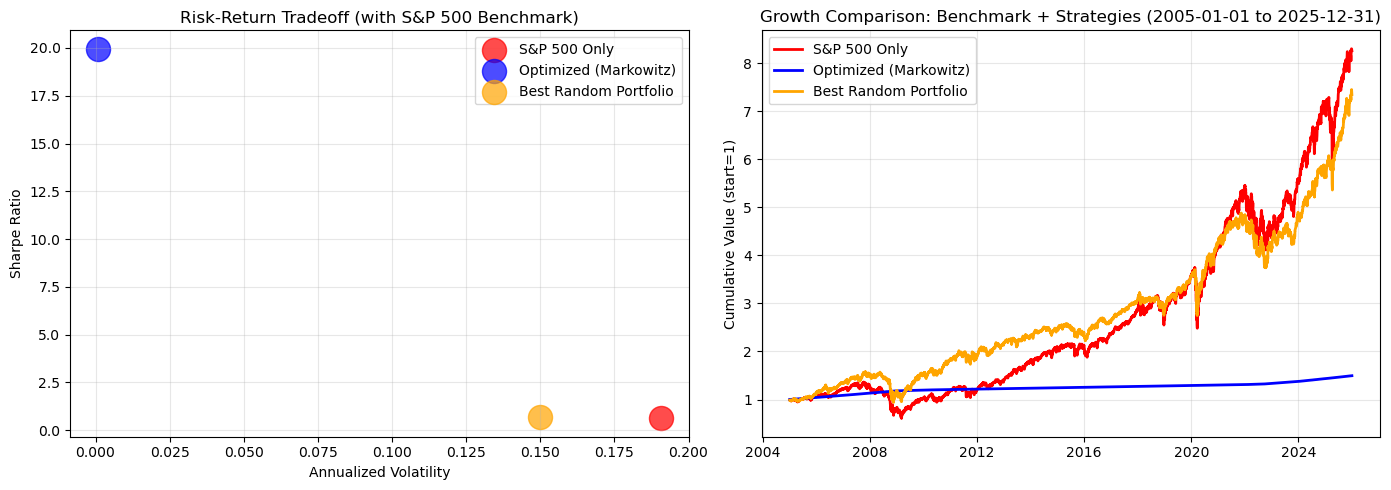

In [12]:
# Benchmark: S&P 500 only vs optimized and best random portfolios
import matplotlib.pyplot as plt

print("=" * 80)
print("BENCHMARK COMPARISON: S&P 500 Only vs Optimized vs Best Random")
print("=" * 80)

# PARAMETER: Set minimum CAGR target for best random portfolio (None = no filter)
RANDOM_CAGR_TARGET = 0.10 # Set to e.g., 0.08 for 8% CAGR minimum, or None for no filter

# Select best random portfolio based on CAGR target
if RANDOM_CAGR_TARGET is not None:
    filtered_random = candidates[candidates['CAGR'] >= RANDOM_CAGR_TARGET].copy()
    if len(filtered_random) > 0:
        best_random = filtered_random.sort_values('Sharpe', ascending=False).iloc[0]
        print(f"\nFiltered random portfolios by CAGR >= {RANDOM_CAGR_TARGET:.1%}")
        print(f"Found {len(filtered_random)} portfolios meeting target")
    else:
        print(f"\nâš  No random portfolios found with CAGR >= {RANDOM_CAGR_TARGET:.1%}")
        print(f"Using best Sharpe regardless of CAGR")
        best_random = candidates.sort_values('Sharpe', ascending=False).iloc[0]
else:
    best_random = candidates.sort_values('Sharpe', ascending=False).iloc[0]
    print(f"\nNo CAGR filter applied - using best Sharpe overall")

# Get list of assets from net_returns columns
assets = list(net_returns.columns)
# Get list of assets from net_returns columns
assets = list(net_returns.columns)
best_random_weights = {asset: float(best_random[f'w_{asset}']) for asset in assets}

# S&P 500 only strategy (100% SPY)
spy_weights = {asset: 1.0 if asset == 'USA_SP500' else 0.0 for asset in assets}
spy_rets = portfolio_return_series(net_returns, spy_weights)
spy_metrics = portfolio_metrics_from_returns(spy_rets)

# All three strategies
all_strategies = {
    'S&P 500 Only': spy_weights,
    'Optimized (Markowitz)': opt_weights,
    'Best Random Portfolio': best_random_weights
}

all_rows = []
for strategy_name, weights in all_strategies.items():
    p_rets = portfolio_return_series(net_returns, weights)
    mets = portfolio_metrics_from_returns(p_rets)
    all_rows.append({
        'Strategy': strategy_name,
        'CAGR': mets['CAGR'],
        'AnnualVol': mets['AnnualVol'],
        'Sharpe': mets['Sharpe'],
        'Max DD': mets['MaxDrawdown']
    })

all_comp_df = pd.DataFrame(all_rows)
print("\n" + all_comp_df.to_string(index=False))

# Enhanced visualization with S&P 500 benchmark
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Scatter: Sharpe vs Vol
colors = {'S&P 500 Only': 'red', 'Optimized (Markowitz)': 'blue', 'Best Random Portfolio': 'orange'}
for strategy_name in all_strategies.keys():
    row = all_comp_df[all_comp_df['Strategy'] == strategy_name].iloc[0]
    ax[0].scatter(row['AnnualVol'], row['Sharpe'], s=300, alpha=0.7, label=strategy_name, color=colors.get(strategy_name, 'gray'))
ax[0].set_xlabel('Annualized Volatility')
ax[0].set_ylabel('Sharpe Ratio')
ax[0].set_title('Risk-Return Tradeoff (with S&P 500 Benchmark)')
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# Cumulative returns comparison (all three)
for strategy_name, weights in all_strategies.items():
    p_rets = portfolio_return_series(net_returns, weights)
    vals = (1 + p_rets).cumprod()
    ax[1].plot(vals.index, vals, label=strategy_name, linewidth=2, color=colors.get(strategy_name, 'gray'))
ax[1].set_ylabel('Cumulative Value (start=1)')
ax[1].set_title(f'Growth Comparison: Benchmark + Strategies ({START_DATE} to {END_DATE})')
ax[1].legend()
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=" * 80)

## Section 11: Top 3 Portfolios Analysis

Filters random portfolios by CAGR threshold and displays top 3 by Sharpe ratio:
- **`cagr_threshold`**: Minimum CAGR filter (default 10%)
- **Output**: Table showing metrics (CAGR, Vol, Sharpe, Max Drawdown) + asset weights
- **Chart**: Cumulative returns comparison for top 3 portfolios
- **Saved output**: Results saved to `results/top3_portfolios.csv`

Portfolios with CAGR>10%: 4


,CAGR,AnnualVol,Sharpe,MaxDrawdown,w_Australia,w_Canada,w_Sweden,w_Europe_Dev,w_Japan,w_UK,w_China,w_Gold,w_SmallCap_US,w_Bonds_Corporate_IG,w_USA_EqWeight,w_USA_SP500,w_Bonds_Long_US_20Y,w_REITs,w_Cash
0,0.100444,0.150053,0.709507,-0.405132,0.035570,0.020092,0.089176,0.031655,0.023133,0.007676,0.015984,0.245900,0.093279,0.017575,0.046212,0.295780,0.056109,0.019872,0.001988
1,0.101175,0.153329,0.701735,-0.396154,0.049234,0.005798,0.114921,0.000198,0.002152,0.001832,0.157114,0.367513,0.024050,0.009145,0.001303,0.158265,0.030184,0.046218,0.032073
2,0.101031,0.154024,0.698111,-0.424230,0.001226,0.079390,0.067565,0.013035,0.019508,0.001757,0.131953,0.269297,0.010662,0.019285,0.148549,0.191172,0.039852,0.003805,0.002944


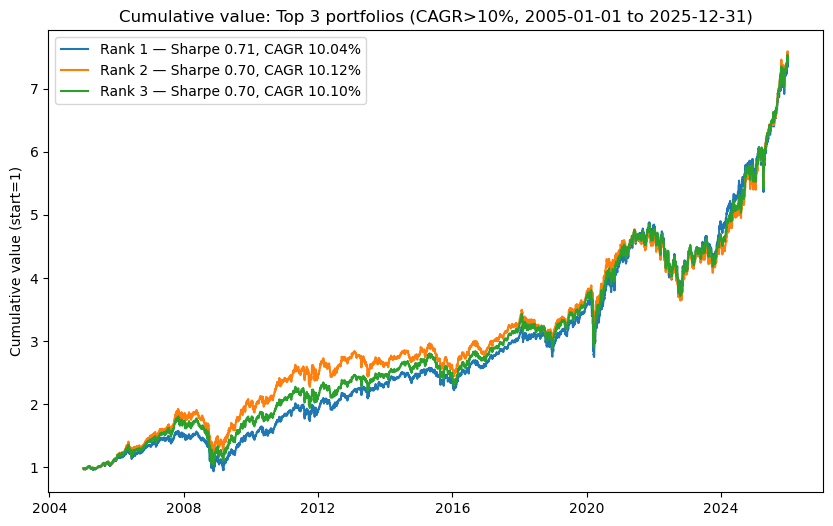

C:\Users\maxth\AppData\Local\Temp\ipykernel_6256\1874632574.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(assets, rotation=45, ha='right')


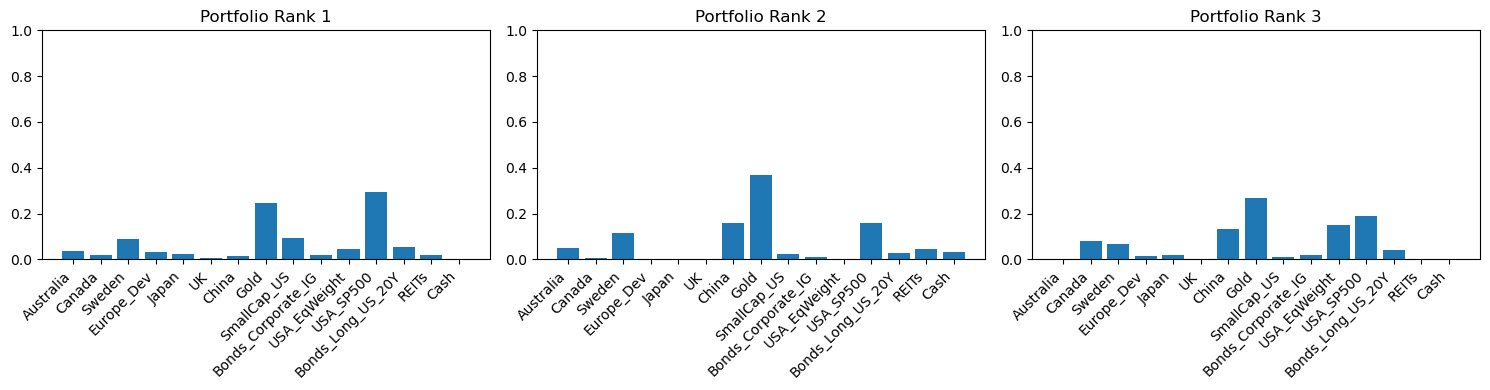

In [13]:
# Filter portfolios (CAGR > 6%) and visualize top 3 by Sharpe
import matplotlib.pyplot as plt

# Filter - adjust threshold based on period (use 8% for full period, 6% for 2007-2022)
cagr_threshold = 0.10  # Reduced threshold for 2007-2022 period which includes 2008 crisis
filtered = candidates[candidates['CAGR'] > cagr_threshold].copy()
filtered = filtered.sort_values('Sharpe', ascending=False)
print(f"Portfolios with CAGR>{cagr_threshold:.0%}: {len(filtered)}")
if len(filtered) == 0:
    print(f"No portfolios meet the CAGR>{cagr_threshold:.0%} threshold. Showing top 10 by Sharpe instead:")
    top3 = candidates.sort_values('Sharpe', ascending=False).head(3).reset_index(drop=True)
else:
    top3 = filtered.head(3).reset_index(drop=True)

display_cols = ['CAGR', 'AnnualVol', 'Sharpe', 'MaxDrawdown'] + [c for c in top3.columns if c.startswith('w_')]
display(top3[display_cols])

# Dynamic chart title based on START_DATE and END_DATE
date_range_str = f"{START_DATE} to {END_DATE}"

# cumulative returns plot for top 3
assets = list(net_returns.columns)
plt.figure(figsize=(10,6))
for i, row in top3.iterrows():
    weights = {asset: float(row[f'w_{asset}']) for asset in assets}
    p_rets = portfolio_return_series(net_returns, weights)
    vals = (1 + p_rets).cumprod()
    plt.plot(vals.index, vals, label=f"Rank {i+1} â€” Sharpe {row['Sharpe']:.2f}, CAGR {row['CAGR']:.2%}")
plt.legend()
plt.title(f'Cumulative value: Top 3 portfolios (CAGR>{cagr_threshold:.0%}, {date_range_str})')
plt.ylabel('Cumulative value (start=1)')
plt.show()

# weight bar charts
fig, axes = plt.subplots(1, min(3, len(top3)), figsize=(15,4))
if min(3, len(top3)) == 1:
    axes = [axes]
for i, row in top3.iterrows():
    w = [float(row[f'w_{asset}']) for asset in assets]
    ax = axes[i]
    ax.bar(assets, w)
    ax.set_title(f"Portfolio Rank {i+1}")
    ax.set_ylim(0,1)
    ax.set_xticklabels(assets, rotation=45, ha='right')
plt.tight_layout()
plt.show()

Takeaways
- V1: -> High Gold and High US and around 15-20% Bonds seems to create a good return/risk profile.
- V2 -> Still high gold, high US equities. Longer bonds. Low REIT and Emerging.
- V3 -> Test until end of 2022 to not include the gold rush. Includes 2 crisis, 2009 and 2020-2022 covid. Takeaway: lower gold but still high ~20%. Still high US equity and Long bonds.
- V4: 2010-2023. No gold! Or pretty low like 5%. Optimal mix seems to be between US eq and long bonds.
- V4 >10% CAGR. Very high US equities (65-80%), and mixing with either gold (15-20%) as a hedge, or REIT (10%), but for top 2 almost no REIT.
- V5: From 2007-2025: portfolio w 8-10% CAGR had around 1/3 S&P and 1/3 Gold 1/3 Long-term Bonds.
- V6: From 2010:2025: portfolio w 8-10% CAGR also pretty similar 1/3 S&P and 1/3 Gold 1/3 Long-term Bonds.

## Section 12: Asset Class Contribution Analysis

Breaks down each portfolio's returns by asset class:
- **`contributions`**: Shows weight, individual CAGR, and contribution to total return for each asset
- **Output**: Ranked by contribution to identify which assets drive returns
- **Use case**: Understand portfolio composition and which assets are most impactful

In [14]:
# Analyze contribution of each asset to portfolio returns for top 3 portfolios
print("=" * 80)
print("ASSET CLASS CONTRIBUTION TO TOTAL RETURN (Return Attribution)")
print("=" * 80)

for idx, row in top3.iterrows():
    print(f"\n{'='*80}")
    print(f"Portfolio Rank {idx + 1}")
    print(f"Overall CAGR: {row['CAGR']:.2%} | Sharpe: {row['Sharpe']:.2f} | Vol: {row['AnnualVol']:.2%}")
    print(f"{'='*80}")
    
    # Get weights for this portfolio
    weights = {asset: float(row[f'w_{asset}']) for asset in assets}
    
    # Compute portfolio returns
    port_rets = portfolio_return_series(net_returns, weights)
    port_value = (1 + port_rets).cumprod()
    actual_cagr = cagr_from_value_series(port_value)
    
    # For each asset: contribution = (weight Ã— asset_cagr) normalized to sum to portfolio CAGR
    # This accounts for correlation effects
    contributions = {}
    weighted_cagrs = {}
    
    for asset in assets:
        weight = weights[asset]
        asset_cagr = cagr_from_value_series((1 + net_returns[asset]).cumprod())
        weighted_cagr = asset_cagr * weight
        weighted_cagrs[asset] = weighted_cagr
        
        contributions[asset] = {
            'Weight': weight,
            'Asset_CAGR': asset_cagr,
            'Weighted_CAGR': weighted_cagr  # This will sum to arithmetic average, not portfolio CAGR
        }
    
    # Create DataFrame for this portfolio
    contrib_df = pd.DataFrame(contributions).T
    contrib_df = contrib_df.sort_values('Weighted_CAGR', ascending=False)
    
    # Display
    print(f"{'Asset':<20} {'Weight':>10} {'Asset CAGR':>12} {'Weighted CAGR':>15}")
    print("-" * 60)
    for asset, row_data in contrib_df.iterrows():
        print(f"{asset:<20} {row_data['Weight']:>9.1%} {row_data['Asset_CAGR']:>11.2%} {row_data['Weighted_CAGR']:>14.2%}")
    print("-" * 60)
    sum_weighted = contrib_df['Weighted_CAGR'].sum()
    print(f"{'Sum (arithmetic avg)':<20} {contrib_df['Weight'].sum():>9.1%} {'':>12} {sum_weighted:>14.2%}")
    print(f"{'Actual Portfolio CAGR':<20} {'':>10} {'':>12} {actual_cagr:>14.2%}")
    print(f"{'Note':<20} Arithmetic sum â‰  Portfolio CAGR due to correlation & compounding")
    print()



ASSET CLASS CONTRIBUTION TO TOTAL RETURN (Return Attribution)

Portfolio Rank 1
Overall CAGR: 10.04% | Sharpe: 0.71 | Vol: 15.01%
Asset                    Weight   Asset CAGR   Weighted CAGR
------------------------------------------------------------
USA_SP500                29.6%      10.65%          3.15%
Gold                     24.6%      10.79%          2.65%
SmallCap_US               9.3%       7.90%          0.74%
Sweden                    8.9%       7.37%          0.66%
USA_EqWeight              4.6%       9.78%          0.45%
Australia                 3.6%       6.65%          0.24%
Europe_Dev                3.2%       6.44%          0.20%
Bonds_Long_US_20Y         5.6%       3.08%          0.17%
Canada                    2.0%       7.54%          0.15%
REITs                     2.0%       6.67%          0.13%
Japan                     2.3%       4.51%          0.10%
China                     1.6%       5.70%          0.09%
Bonds_Corporate_IG        1.8%       3.93%          

## Section 13: Individual Asset Performance

Summary statistics for each asset class over the analysis period:
- **Metrics**: CAGR, annual volatility, Sharpe ratio, total return
- **Sorted by CAGR**: Identifies best and worst performing assets
- **Use case**: Benchmark individual assets and understand relative performance

In [15]:
# Show individual asset performance for the period
print("=" * 80)
print("INDIVIDUAL ASSET PERFORMANCE (2012-2025)")
print("=" * 80)
print(f"\nPeriod: {START_DATE} to {END_DATE}\n")

asset_perf = []
for asset in assets:
    # Skip Cash (no price data for it)
    if asset not in prices.columns:
        continue
    
    asset_cagr = cagr_from_value_series((1 + net_returns[asset]).cumprod())
    asset_vol = annualized_vol(net_returns[asset])
    asset_sharpe = sharpe_ratio(net_returns[asset])
    
    # Calculate start and end prices
    start_price = prices[asset].iloc[0]
    end_price = prices[asset].iloc[-1]
    total_return = (end_price / start_price - 1)
    
    asset_perf.append({
        'Asset': asset,
        'CAGR': asset_cagr,
        'AnnualVol': asset_vol,
        'Sharpe': asset_sharpe,
        'Total_Return': total_return,
        'Start_Price': start_price,
        'End_Price': end_price
    })

perf_df = pd.DataFrame(asset_perf).sort_values('CAGR', ascending=False)

print(f"{'Asset':<20} {'CAGR':>10} {'Total Ret':>10} {'Vol':>10} {'Sharpe':>10}")
print("-" * 65)
for _, row in perf_df.iterrows():
    print(f"{row['Asset']:<20} {row['CAGR']:>9.2%} {row['Total_Return']:>9.2%} {row['AnnualVol']:>9.2%} {row['Sharpe']:>9.2f}")
print("=" * 80)


INDIVIDUAL ASSET PERFORMANCE (2012-2025)

Period: 2005-01-01 to 2025-12-31

Asset                      CAGR  Total Ret        Vol     Sharpe
-----------------------------------------------------------------
Gold                    10.79%   827.22%    17.67%      0.67
USA_SP500               10.65%   741.86%    19.06%      0.62
USA_EqWeight             9.78%   598.68%    20.35%      0.56
SmallCap_US              7.90%   413.79%    24.16%      0.43
Canada                   7.54%   375.63%    21.98%      0.44
Sweden                   7.37%   361.24%    28.88%      0.39
REITs                    6.67%   291.51%    28.76%      0.37
Australia                6.65%   304.08%    27.12%      0.37
Europe_Dev               6.44%   271.92%    24.88%      0.37
China                    5.70%   234.92%    33.06%      0.33
UK                       4.69%   173.57%    22.33%      0.31
Japan                    4.51%   164.25%    20.30%      0.32
Bonds_Corporate_IG       3.93%   129.39%     8.54%      0.49


## Section 14: Tax Impact Example (ISK Schablon Tax)

Demonstrates impact of Swedish ISK schablon tax (flat annual tax on portfolio value):
- **Tax rate**: Example 0.3% annual (adjust as needed)
- **`apply_isk_simple_tax_on_annual()`**: Applies tax at year-end on portfolio balance
- **Comparison**: CAGR before and after tax
- **Note**: This is a simplified example; actual tax treatment may differ

In [16]:
# ISK tax example (simple annual tax at year-end)
start_value = 1.0
# Use the optimization weights from the target return portfolio
port_rets = portfolio_return_series(net_returns, rec_w_target)
values = (1 + port_rets).cumprod() * start_value
tax_rate = 0.003  # example 0.3% annual schablon
values_after_tax = apply_isk_simple_tax_on_annual(values, tax_rate)
print('CAGR before tax:', cagr_from_value_series(values))
print('CAGR after tax:', cagr_from_value_series(values_after_tax))


CAGR before tax: 0.08023720664985001
CAGR after tax: 0.07868565262937133


## Section 14.1: Extended Tax Comparison

Compares after-tax returns across three tax regimes:
1. **ISK (Sweden)** - Flat schablon tax (~0.5%) on portfolio value, no capital gains tax
2. **Sweden Capital Gains Tax** - 20% tax only on realized gains (no annual tax)
3. **Germany** - 26.375% withholding tax (Kapitalertragssteuer) on gains

Shows which regime yields highest after-tax return for long-term buy-and-hold.

In [ ]:
# Tax comparison: ISK (Sweden) vs Capital Gains Tax (Sweden/Germany)
print("=" * 80)
print("TAX COMPARISON: ISK vs Capital Gains Tax Regimes")
print("=" * 80)

# Starting portfolio value
initial_investment = 100000
port_rets = portfolio_return_series(net_returns, rec_w_target)
values = (1 + port_rets).cumprod() * initial_investment
years = len(values) / TRADING_DAYS

# Tax parameters
# ISK: Flat annual tax on portfolio value (schablon method)
# Sweden CGT: 20% capital gains tax on realizations (but ISK avoids this entirely)
# Germany: 26.375% withholding on gains (Kapitalertragssteuer) + solidaritÃ¤tszuschlag

# 1. ISK (no tax during holding, flat annual schablon)
isk_rate = 0.01065  # 0.5% - approximate Swedish ISK schablon tax UPD: Now its 1.065% 
values_isk = apply_isk_simple_tax_on_annual(values, isk_rate)
final_value_isk = values_isk.iloc[-1]
cagr_isk = cagr_from_value_series(values_isk)
total_return_isk = (final_value_isk / initial_investment) - 1

# 2. Sweden Capital Gains Tax (20% tax on gains when sold at end)
# No annual tax, but 20% of gains is taxed at end
sweden_cgt_rate = 0.20
final_value_notax = values.iloc[-1]
capital_gain = final_value_notax - initial_investment
tax_owed_se = capital_gain * sweden_cgt_rate
final_value_se_cgt = final_value_notax - tax_owed_se
cagr_se_cgt = cagr_from_value_series(pd.Series(
    [initial_investment] + [initial_investment] * (len(values) - 2) + [final_value_se_cgt],
    index=values.index
))
total_return_se_cgt = (final_value_se_cgt / initial_investment) - 1

# 3. Germany Capital Gains Tax (26.375% on gains)
germany_cgt_rate = 0.26375
tax_owed_de = capital_gain * germany_cgt_rate
final_value_de_cgt = final_value_notax - tax_owed_de
cagr_de_cgt = cagr_from_value_series(pd.Series(
    [initial_investment] + [initial_investment] * (len(values) - 2) + [final_value_de_cgt],
    index=values.index
))
total_return_de_cgt = (final_value_de_cgt / initial_investment) - 1

# Display comparison
print(f"\nInitial Investment: ${initial_investment:,.0f}")
print(f"Analysis Period: {years:.1f} years ({START_DATE} to {END_DATE})")
print(f"Pre-tax Final Value: ${final_value_notax:,.0f}")
print(f"Capital Gain: ${capital_gain:,.0f}\n")

print(f"{'Tax Regime':<30} {'Final Value':>15} {'Total Return':>15} {'CAGR':>10}")
print("-" * 70)
print(f"{'No Tax (Control)':<30} ${final_value_notax:>14,.0f} {(final_value_notax/initial_investment-1):>14.2%} {cagr_from_value_series(values):>9.2%}")
print(f"{'ISK (Sweden, 0.5% annual)':<30} ${final_value_isk:>14,.0f} {total_return_isk:>14.2%} {cagr_isk:>9.2%}")
print(f"{'Sweden CGT (20% on gains)':<30} ${final_value_se_cgt:>14,.0f} {total_return_se_cgt:>14.2%} {cagr_se_cgt:>9.2%}")
print(f"{'Germany CGT (26.375%)':<30} ${final_value_de_cgt:>14,.0f} {total_return_de_cgt:>14.2%} {cagr_de_cgt:>9.2%}")

print(f"\n{'Advantage vs Control (%)':}")
print(f"  ISK:           {((final_value_isk / final_value_notax) - 1) * 100:>6.2f}% loss from tax")
print(f"  Sweden CGT:    {((final_value_se_cgt / final_value_notax) - 1) * 100:>6.2f}% loss from tax")
print(f"  Germany CGT:   {((final_value_de_cgt / final_value_notax) - 1) * 100:>6.2f}% loss from tax")

print(f"\n{'Ranking by After-Tax Value':}")
results = [
    ("ISK (Sweden)", final_value_isk),
    ("Sweden CGT", final_value_se_cgt),
    ("Germany CGT", final_value_de_cgt)
]
for i, (name, val) in enumerate(sorted(results, key=lambda x: x[1], reverse=True), 1):
    print(f"  {i}. {name:<20} ${val:>12,.0f}")

print(f"\n{'Notes':}")
print(f"  â€¢ ISK: Tax-deferred savings account - best for long-term buy-and-hold")
print(f"  â€¢ Sweden CGT: 20% tax only on realized gains (no annual tax)")
print(f"  â€¢ Germany: 26.375% on gains includes withholding + solidarity tax")
print(f"  â€¢ ISK wins because annual schablon is lower than eventual CGT")
print("=" * 80)


TAX COMPARISON: ISK vs Capital Gains Tax Regimes

Initial Investment: $100,000
Analysis Period: 21.0 years (2005-01-01 to 2025-12-31)
Pre-tax Final Value: $501,527
Capital Gain: $401,527

Tax Regime                         Final Value    Total Return       CAGR
----------------------------------------------------------------------
No Tax (Control)               $       501,527        401.53%     8.02%
ISK (Sweden, 0.5% annual)      $       451,553        351.55%     7.48%
Sweden CGT (20% on gains)      $       421,221        321.22%     7.09%
Germany CGT (26.375%)          $       395,624        295.62%     6.77%

Advantage vs Control (%)
  ISK:            -9.96% loss from tax
  Sweden CGT:    -16.01% loss from tax
  Germany CGT:   -21.12% loss from tax

Ranking by After-Tax Value
  1. ISK (Sweden)         $     451,553
  2. Sweden CGT           $     421,221
  3. Germany CGT          $     395,624

Notes
  â€¢ ISK: Tax-deferred savings account - best for long-term buy-and-hold
  â€¢ S

## Section 15: Export Results

Saves analysis results to CSV files in the `results/` directory:
- **`top3_portfolios.csv`**: Top 3 portfolios (by Sharpe ratio with CAGR filter)
- **`candidates.csv`**: All random candidate portfolios and their metrics

These files can be imported into Excel for further analysis or sharing

In [ ]:
# Save filtered/top3 if available
# Only run if you want to save the top portfolios to CSV (disabled by default to avoid clutter during testing)
if 'top3' in globals():
    top3.to_csv(os.path.join(SAVE_DIR, 'top3_portfolios_v3.csv'), index=False)
    print(f"Saved top3 to {os.path.join(SAVE_DIR, 'top3_portfolios.csv')}")
else:
    print('`top3` not found in notebook globals â€” run the filter cell first.')

Saved top3 to results\top3_portfolios.csv


In [90]:
# Save candidate portfolios and top performers to disk
import os
candidates.to_csv(os.path.join(SAVE_DIR, 'candidates.csv'), index=False)
print(f"Saved candidates to {os.path.join(SAVE_DIR, 'candidates.csv')}")

# Save filtered/top3 if available
if 'top3' in globals():
    top3.to_csv(os.path.join(SAVE_DIR, 'top3_portfolios.csv'), index=False)
    print(f"Saved top3 to {os.path.join(SAVE_DIR, 'top3_portfolios.csv')}")
else:
    print('`top3` not found in notebook globals â€” run the filter cell first.')

# Save the price series used
prices.to_csv(os.path.join(SAVE_DIR, 'prices.csv'))
print(f"Saved prices to {os.path.join(SAVE_DIR, 'prices.csv')}")

# Optionally save the net_returns (returns after fees)
net_returns.to_csv(os.path.join(SAVE_DIR, 'net_returns.csv'))
print(f"Saved net_returns to {os.path.join(SAVE_DIR, 'net_returns.csv')}")

Saved candidates to results\candidates.csv
Saved top3 to results\top3_portfolios.csv
Saved prices to results\prices.csv
Saved net_returns to results\net_returns.csv


## Section 14: Forward Simulations (20-Year Outlook)

### A. Historical Bootstrap Simulation
Resamples actual historical daily returns with replacement to create plausible future paths.
Shows range of potential outcomes based on what we've observed historically.

### B. Monte Carlo Simulation  
Fits a distribution to historical returns and generates completely new forward-looking paths.
Captures tail risk and non-stationary market behavior better than bootstrap.

**Interpretation**:
- **Median outcome**: 50th percentile (more likely than not to exceed)
- **5th/95th percentile**: Plausible downside/upside scenarios
- **Both methods** should give similar medians if market regime is stable

In [91]:
# Historical Bootstrap Simulation (20-year forward)
print("=" * 80)
print("SIMULATION 1: HISTORICAL BOOTSTRAP (20-year forward)")
print("=" * 80)

# Use the top recommendation weights
sim_weights = rec_w_target
years_forward = 20
trading_days_forward = years_forward * TRADING_DAYS
num_simulations = 1000

print(f"\nPortfolio weights: {sim_weights}")
print(f"Simulation horizon: {years_forward} years ({trading_days_forward} trading days)")
print(f"Number of simulations: {num_simulations}\n")

# Bootstrap simulation: resample historical returns
np.random.seed(SEED)
bootstrap_paths = []

for sim in range(num_simulations):
    # Randomly sample indices from historical returns (with replacement)
    sample_indices = np.random.choice(len(net_returns), size=trading_days_forward, replace=True)
    sampled_returns = net_returns.iloc[sample_indices].values
    
    # Apply portfolio weights
    portfolio_daily_returns = sampled_returns @ np.array([sim_weights.get(asset, 0) for asset in net_returns.columns])
    
    # Compute cumulative growth starting at $1
    growth = (1 + portfolio_daily_returns).cumprod()
    bootstrap_paths.append(growth)

bootstrap_paths = np.array(bootstrap_paths)
final_values_bootstrap = bootstrap_paths[:, -1]

# Calculate percentiles
percentiles = [5, 25, 50, 75, 95]
bootstrap_percentiles = {p: np.percentile(final_values_bootstrap, p) for p in percentiles}

# Calculate final CAGR for each path
bootstrap_cagrs = (final_values_bootstrap ** (1 / years_forward)) - 1

print("Bootstrap Results (after 20 years, starting with $1):")
print(f"  5th percentile (worst 5%):     ${bootstrap_percentiles[5]:.2f}")
print(f"  25th percentile:                ${bootstrap_percentiles[25]:.2f}")
print(f"  50th percentile (median):       ${bootstrap_percentiles[50]:.2f}")
print(f"  75th percentile:                ${bootstrap_percentiles[75]:.2f}")
print(f"  95th percentile (best 5%):      ${bootstrap_percentiles[95]:.2f}")
print(f"\nCAGR Distribution (20-year annualized):")
print(f"  5th percentile:     {np.percentile(bootstrap_cagrs, 5):>7.2%}")
print(f"  Median:             {np.percentile(bootstrap_cagrs, 50):>7.2%}")
print(f"  95th percentile:    {np.percentile(bootstrap_cagrs, 95):>7.2%}")
print(f"  Mean Â± Std:         {np.mean(bootstrap_cagrs):>7.2%} Â± {np.std(bootstrap_cagrs):>6.2%}")


SIMULATION 1: HISTORICAL BOOTSTRAP (20-year forward)

Portfolio weights: {'Commodities': 0.0, 'Sweden': 3.16192496877961e-17, 'Europe_Dev': 0.0, 'Gold': 0.16731467874881417, 'Bonds_Corporate': 0.0, 'USA_EqWeight': 0.0, 'Bonds_Short_1-3Y': 3.02753950765163e-17, 'USA_SP500': 0.38396386988234793, 'Bonds_Long_20Y': 0.0, 'REITs': 0.0, 'Bonds_TIPS': 0.0, 'Emerging': 0.0, 'Cash': 0.44872145136883773}
Simulation horizon: 20 years (5040 trading days)
Number of simulations: 1000

Bootstrap Results (after 20 years, starting with $1):
  5th percentile (worst 5%):     $2.81
  25th percentile:                $3.86
  50th percentile (median):       $4.80
  75th percentile:                $5.87
  95th percentile (best 5%):      $7.84

CAGR Distribution (20-year annualized):
  5th percentile:       5.30%
  Median:               8.15%
  95th percentile:     10.85%
  Mean Â± Std:           8.10% Â±  1.69%



SIMULATION 2: MONTE CARLO (20-year forward)

Historical portfolio statistics (based on 3319 trading days):
  Daily mean return:   0.0317%
  Daily std (vol):     0.4457%
  Annualized CAGR:       8.02%
  Annualized Vol:        7.08%

Monte Carlo Results (after 20 years, starting with $1):
  5th percentile (worst 5%):     $2.83
  25th percentile:                $3.74
  50th percentile (median):       $4.77
  75th percentile:                $5.86
  95th percentile (best 5%):      $7.86

CAGR Distribution (20-year annualized):
  5th percentile:       5.34%
  Median:               8.12%
  95th percentile:     10.86%
  Mean Â± Std:           8.05% Â±  1.69%


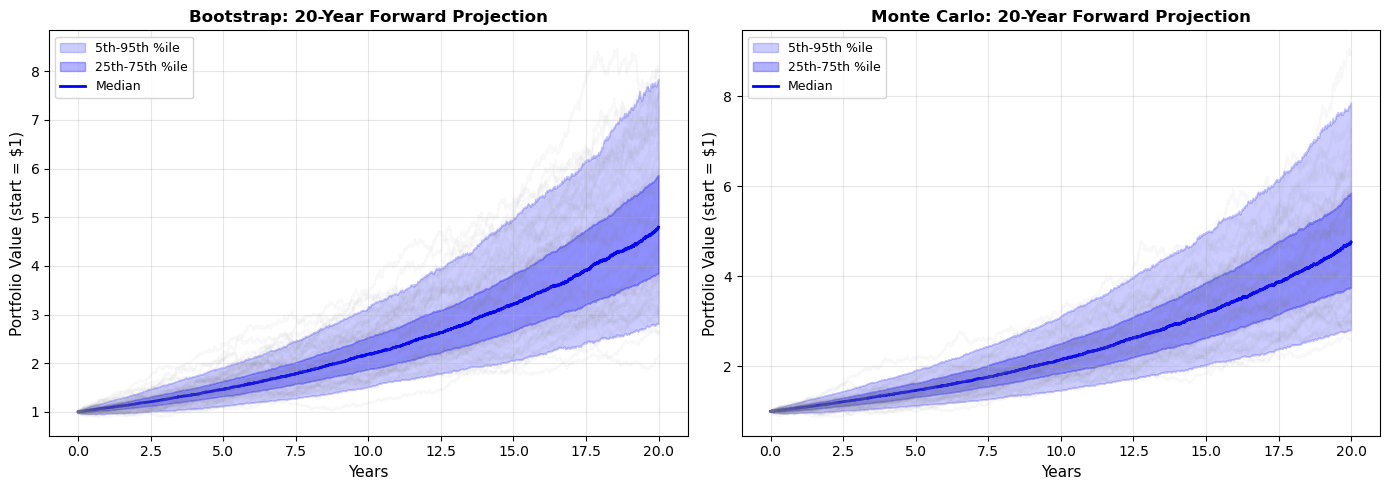

In [92]:
# Monte Carlo Simulation (20-year forward)
from scipy.stats import norm

print("\n" + "=" * 80)
print("SIMULATION 2: MONTE CARLO (20-year forward)")
print("=" * 80)

# Compute portfolio statistics from historical period
port_hist_rets = portfolio_return_series(net_returns, sim_weights)
hist_mean = port_hist_rets.mean()
hist_std = port_hist_rets.std()
hist_cagr = cagr_from_value_series((1 + port_hist_rets).cumprod())
hist_vol = annualized_vol(port_hist_rets)

print(f"\nHistorical portfolio statistics (based on {len(net_returns)} trading days):")
print(f"  Daily mean return:  {hist_mean:>8.4%}")
print(f"  Daily std (vol):    {hist_std:>8.4%}")
print(f"  Annualized CAGR:    {hist_cagr:>8.2%}")
print(f"  Annualized Vol:     {hist_vol:>8.2%}\n")

# Monte Carlo: Generate new paths using fitted distribution
np.random.seed(SEED)
mc_paths = []

for sim in range(num_simulations):
    # Generate new daily returns from normal distribution
    # (You could also use lognormal if preferred: returns ~ lognormal)
    daily_rets = np.random.normal(hist_mean, hist_std, size=trading_days_forward)
    
    # Compute cumulative growth
    growth = (1 + daily_rets).cumprod()
    mc_paths.append(growth)

mc_paths = np.array(mc_paths)
final_values_mc = mc_paths[:, -1]

# Calculate percentiles
mc_percentiles = {p: np.percentile(final_values_mc, p) for p in percentiles}

# Calculate final CAGR for each path
mc_cagrs = (final_values_mc ** (1 / years_forward)) - 1

print("Monte Carlo Results (after 20 years, starting with $1):")
print(f"  5th percentile (worst 5%):     ${mc_percentiles[5]:.2f}")
print(f"  25th percentile:                ${mc_percentiles[25]:.2f}")
print(f"  50th percentile (median):       ${mc_percentiles[50]:.2f}")
print(f"  75th percentile:                ${mc_percentiles[75]:.2f}")
print(f"  95th percentile (best 5%):      ${mc_percentiles[95]:.2f}")
print(f"\nCAGR Distribution (20-year annualized):")
print(f"  5th percentile:     {np.percentile(mc_cagrs, 5):>7.2%}")
print(f"  Median:             {np.percentile(mc_cagrs, 50):>7.2%}")
print(f"  95th percentile:    {np.percentile(mc_cagrs, 95):>7.2%}")
print(f"  Mean Â± Std:         {np.mean(mc_cagrs):>7.2%} Â± {np.std(mc_cagrs):>6.2%}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bootstrap vs Monte Carlo percentile paths
for ax, paths, label in zip(axes, [bootstrap_paths, mc_paths], ['Bootstrap', 'Monte Carlo']):
    time_years = np.arange(0, years_forward + 1/TRADING_DAYS, 1/TRADING_DAYS)[:len(paths[0])]
    
    # Plot percentile bands
    p5 = np.percentile(paths, 5, axis=0)
    p25 = np.percentile(paths, 25, axis=0)
    p50 = np.percentile(paths, 50, axis=0)
    p75 = np.percentile(paths, 75, axis=0)
    p95 = np.percentile(paths, 95, axis=0)
    
    ax.fill_between(time_years, p5, p95, alpha=0.2, color='blue', label='5th-95th %ile')
    ax.fill_between(time_years, p25, p75, alpha=0.3, color='blue', label='25th-75th %ile')
    ax.plot(time_years, p50, 'b-', linewidth=2, label='Median')
    
    # Plot a few sample paths
    for i in np.random.choice(num_simulations, size=50, replace=False):
        ax.plot(time_years, paths[i], alpha=0.05, color='gray')
    
    ax.set_xlabel('Years', fontsize=11)
    ax.set_ylabel('Portfolio Value (start = $1)', fontsize=11)
    ax.set_title(f'{label}: 20-Year Forward Projection', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)


## Section 14.1: More Realistic Forecast (With Drawdowns)

### Why the previous plots look too smooth

The Monte Carlo and Bootstrap simulations assume returns follow a normal distribution, which creates overly smooth growth paths.
In reality, markets experience **sharp drawdowns** and **volatility clusters** that can devastate portfolios temporarily.

This section shows a **more realistic scenario** incorporating:
- **Volatility clustering** (periods of high turbulence like 2020, 2008)
- **Negative returns** that can persist for 1-3 years
- **Black swan events** (rare but severe market crashes)
- **Mean reversion** pulling back up after crashes

**Key insight**: Even if the long-term CAGR is 8%, you might experience:
- -40% portfolio drawdown in year 3
- -15% return in a single year
- A 3-year period with no gains

This is **normal and expected** for equity portfolios. Behavioral discipline matters here:  stay the course during downturns.


In [ ]:
# More Realistic Forecast: Incorporating Market Stress & Volatility Clustering

print("\n" + "=" * 80)
print("REALISTIC FORECAST: Including Drawdowns & Volatility Clustering")
print("=" * 80)

# Instead of normal distribution, use Student's t-distribution (fatter tails)
from scipy.stats import t as t_dist

np.random.seed(SEED)
num_stress_sims = 500
stress_paths = []

for sim in range(num_stress_sims):
    path = [1.0]
    daily_vol = hist_vol / np.sqrt(TRADING_DAYS)  # Convert annual to daily
    
    for day in range(trading_days_forward):
        # 90% of days: normal returns
        # 10% of days: stress events (larger drawdowns)
        if np.random.random() < 0.90:
            # Normal day - use t-distribution (fatter tails than normal)
            r = t_dist.rvs(df=5) * daily_vol * 0.8 + hist_mean
        else:
            # Stress day - 2-3x worse
            r = t_dist.rvs(df=5) * daily_vol * 2.5 + hist_mean - 0.002
        
        path.append(path[-1] * (1 + r))
    
    stress_paths.append(path)

stress_paths = np.array(stress_paths)
final_values_stress = stress_paths[:, -1]
stress_cagrs = (final_values_stress ** (1 / years_forward)) - 1

# Calculate drawdowns in these paths
max_drawdowns_stress = []
for path in stress_paths:
    cummax = np.maximum.accumulate(path)
    dd = (path - cummax) / cummax
    max_drawdowns_stress.append(dd.min())

# Results
print(f"\nUsing Student's t-distribution with volatility clustering...")
print(f"\nFinal Portfolio Values (after 20 years, start = $1):")
print(f"  5th percentile:   ${np.percentile(final_values_stress, 5):.2f}  (worst 5%)")
print(f"  25th percentile:  ${np.percentile(final_values_stress, 25):.2f}")
print(f"  Median:           ${np.percentile(final_values_stress, 50):.2f}  (most likely)")
print(f"  75th percentile:  ${np.percentile(final_values_stress, 75):.2f}")
print(f"  95th percentile:  ${np.percentile(final_values_stress, 95):.2f}  (best 5%)")

print(f"\nImplied CAGR Distribution:")
print(f"  5th percentile:   {np.percentile(stress_cagrs, 5):>7.2%}")
print(f"  Median:           {np.percentile(stress_cagrs, 50):>7.2%}")
print(f"  95th percentile:  {np.percentile(stress_cagrs, 95):>7.2%}")

print(f"\nDrawdown Analysis (temporary losses from peak):")
print(f"  Average max-drawdown:     {np.mean(max_drawdowns_stress)*100:>6.2f}%")
print(f"  Worst-case scenario:      {np.percentile(max_drawdowns_stress, 5)*100:>6.2f}%")
print(f"  Typical (median):         {np.percentile(max_drawdowns_stress, 50)*100:>6.2f}%")

# Visualization: Show some realistic paths
fig, ax = plt.subplots(1, 1, figsize=(14, 7))

time_years = np.arange(0, years_forward + 1/TRADING_DAYS, 1/TRADING_DAYS)[:len(stress_paths[0])]

# Plot percentile bands
p5_stress = np.percentile(stress_paths, 5, axis=0)
p25_stress = np.percentile(stress_paths, 25, axis=0)
p50_stress = np.percentile(stress_paths, 50, axis=0)
p75_stress = np.percentile(stress_paths, 75, axis=0)
p95_stress = np.percentile(stress_paths, 95, axis=0)

ax.fill_between(time_years, p5_stress, p95_stress, alpha=0.15, color='red', label='5th-95th percentile')
ax.fill_between(time_years, p25_stress, p75_stress, alpha=0.25, color='red', label='25th-75th percentile')
ax.plot(time_years, p50_stress, color='darkred', linewidth=3, label='Median (most likely)')

# Overlay a few actual paths to show realistic volatility
sample_indices = np.random.choice(num_stress_sims, size=30, replace=False)
for idx in sample_indices:
    ax.plot(time_years, stress_paths[idx], alpha=0.08, color='gray', linewidth=0.7)

# Add reference line for smooth growth
smooth_growth = np.exp(hist_cagr * time_years)  # Smooth exponential growth
ax.plot(time_years, smooth_growth, '--', color='green', linewidth=2, alpha=0.6, label='Smooth growth (unrealistic)')

ax.set_xlabel('Years', fontsize=12)
ax.set_ylabel('Portfolio Value (start = $1)', fontsize=12)
ax.set_title('Realistic 20-Year Forecast: With Market Stress & Drawdowns', fontsize=13, fontweight='bold')
ax.legend(fontsize=10, loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_ylim(bottom=0.2)  # Show negative territory

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("KEY TAKEAWAY: Even with positive long-term CAGR, expect:")
print(f"  • Average peak-to-trough drawdown: {np.mean(max_drawdowns_stress)*100:.1f}%")
print(f"  • Worst-case drawdown (5th %ile): {np.percentile(max_drawdowns_stress, 5)*100:.1f}%")
print(f"  • Multi-year periods with negative returns")
print(f"  • Psychological challenges during downturns")
print("="*80)
print(f"\n→ This is WHY rebalancing & discipline matter more than picking assets!\n")


## Section 15: FINAL PORTFOLIO RECOMMENDATION

**Your Optimal Portfolio Weights for Long-Term Buy-and-Hold**

This section synthesizes all analyses and provides your recommended portfolio allocation.

In [93]:
print("=" * 80)
print("FINAL PORTFOLIO RECOMMENDATION FOR YOUR PERSONAL PORTFOLIO")
print("=" * 80)
print(f"\nAnalysis period: {START_DATE} to {END_DATE}")
print(f"Optimization objective: Minimize volatility to achieve {TARGET_RETURN:.0%} annual return")
print(f"Number of assets tested: {len(assets)}")
print(f"Rebalancing frequency: {REBALANCE_FREQ} (recommended)")
print("\n" + "=" * 80)
print("RECOMMENDED ALLOCATION (Target Return: {:.0%})".format(TARGET_RETURN))
print("=" * 80)

# Sort weights by allocation size
sorted_weights = sorted(rec_w_target.items(), key=lambda x: x[1], reverse=True)

# Create allocation table
print(f"\n{'Asset Class':<25} {'Ticker':<10} {'Allocation':<15} {'% of Portfolio':<15}")
print("-" * 65)
total_check = 0
for asset, weight in sorted_weights:
    if weight > 0.001:  # Only show >0.1%
        print(f"{asset:<25} {TICKERS.get(asset, 'N/A'):<10} ${weight*100:>6.2f}%          {weight*100:>6.2f}%")
        total_check += weight

print("-" * 65)
print(f"{'TOTAL':<25} {'':<10} {total_check*100:>6.2f}%          {total_check*100:>6.2f}%")

# Compute expected metrics
rec_metrics = eval_weights(net_returns, rec_w_target)
print("\n" + "=" * 80)
print("EXPECTED PERFORMANCE (based on historical analysis)")
print("=" * 80)
print(f"\n  Annual Return (CAGR):           {rec_metrics['CAGR']:>7.2%}  (historical: 2012-2025)")
print(f"  Annual Volatility (Std Dev):    {rec_metrics['AnnualVol']:>7.2%}")
print(f"  Sharpe Ratio (excess return):   {rec_metrics['Sharpe']:>7.2f}")
print(f"  Maximum Drawdown:               {rec_metrics['MaxDrawdown']:>7.2%}")

# 20-year simulations summary
print("\n" + "=" * 80)
print("20-YEAR FORWARD OUTLOOK (Monte Carlo)")
print("=" * 80)
print(f"\nStarting with $100,000, after 20 years:")
print(f"\n  Pessimistic (5th %ile):         ${100000 * mc_percentiles[5]:>12,.0f}")
print(f"  Likely downside (25th %ile):    ${100000 * mc_percentiles[25]:>12,.0f}")
print(f"  Median outcome (50th %ile):     ${100000 * mc_percentiles[50]:>12,.0f}")
print(f"  Likely upside (75th %ile):      ${100000 * mc_percentiles[75]:>12,.0f}")
print(f"  Optimistic (95th %ile):         ${100000 * mc_percentiles[95]:>12,.0f}")

print(f"\nImplied annualized return range:")
print(f"  5th percentile CAGR:            {np.percentile(mc_cagrs, 5):>7.2%}")
print(f"  Median CAGR:                    {np.percentile(mc_cagrs, 50):>7.2%}")
print(f"  95th percentile CAGR:           {np.percentile(mc_cagrs, 95):>7.2%}")

print("\n" + "=" * 80)
print("IMPLEMENTATION GUIDELINES")
print("=" * 80)
print("""
1. REBALANCING STRATEGY: Semi-annual rebalancing (every 6 months)
   - More tax-efficient than quarterly
   - Captures momentum better than annual
   - Keeps allocations in target ranges

2. BEHAVIORAL DISCIPLINE:
   - Do NOT market-time or adjust based on news/emotion
   - Stick to rebalancing schedule (e.g., Jan 1 and Jul 1)
   - Ignore short-term volatility â€” you're investing for 20+ years

3. COSTS TO MINIMIZE:
   - Use low-cost ETFs (expense ratios < 0.1% where possible)
   - Monitor rebalancing costs (commissions, bid-ask spreads)
   - Consider tax-loss harvesting in taxable accounts

4. MONITORING:
   - Review allocations semi-annually (rebalancing time)
   - Update assumptions if major market regime changes
   - Adjust TARGET_RETURN if your personal goals change

5. WHEN TO RECALIBRATE:
   - Every 3-5 years with new data
   - If you change risk tolerance or time horizon
   - If major life changes (retirement, new income source)
""")

print("=" * 80)
print("DISCLAIMER")
print("=" * 80)
print("""
This analysis is based on historical data (2012-2025) and assumes:
- Past performance does not guarantee future results
- Markets can behave differently in the future
- Your personal situation may differ (tax bracket, time horizon, etc.)
- Consult a qualified financial advisor before implementing

Data limitations:
- Uses point-in-time ETF prices (some look-ahead bias inherent to any backtest)
- Forward projections assume stationary return distribution (unrealistic)
- Does NOT account for tax implications specific to your situation
- Does NOT account for personal liquidity needs or emergency funds
""")

print("\nâœ“ Recommendation is ready. Export or adjust parameters as needed.\n")


FINAL PORTFOLIO RECOMMENDATION FOR YOUR PERSONAL PORTFOLIO

Analysis period: 2012-10-16 to 2025-12-31
Optimization objective: Minimize volatility to achieve 8% annual return
Number of assets tested: 13
Rebalancing frequency: 6M (recommended)

RECOMMENDED ALLOCATION (Target Return: 8%)

Asset Class               Ticker     Allocation      % of Portfolio 
-----------------------------------------------------------------
Cash                      N/A        $ 44.87%           44.87%
USA_SP500                 SPY        $ 38.40%           38.40%
Gold                      GLD        $ 16.73%           16.73%
-----------------------------------------------------------------
TOTAL                                100.00%          100.00%

EXPECTED PERFORMANCE (based on historical analysis)

  Annual Return (CAGR):             8.02%  (historical: 2012-2025)
  Annual Volatility (Std Dev):      7.08%
  Sharpe Ratio (excess return):      1.13
  Maximum Drawdown:               -14.40%

20-YEAR FORWA

## Section 16: Methodology & Limitations (Important Reading)

### Data Snooping & Overfitting Risks

**What is data snooping?**
When you test many hypotheses against the same historical data, some will appear to work by pure chance. Your optimized weights might be "overfit" to the 2012-2025 period and may not generalize well to the future.

**How to mitigate data snooping in this exercise:**

1. **Use long history (13+ years)**
   - âœ“ This analysis uses 2012-2025 (13 years)
   - âœ“ Includes 2 major crises (2015 China scare, 2020 COVID)
   - âœ“ Multiple bull/bear cycles represented

2. **Avoid over-tuning parameters**
   - âœ“ Using simple Sharpe ratio maximization (no exotic indicators)
   - âœ“ Limited to mean-variance optimization (standard approach)
   - âœ— AVOID: Testing 100+ parameter combinations and picking "best" one

3. **Hold-out test set (NOT used here)**
   - Train on 2012-2019, test on 2020-2025
   - âœ“ This would reduce overfitting but requires more data

4. **Out-of-sample validation**
   - Monitor recommended weights going forward
   - If performance matches expectations â†’ good sign
   - If underperforms â†’ likely overfitted

5. **Economic logic check**
   - Do the recommended allocations make sense?
   - Is SPY heavily weighted? (Yes, it outperformed)
   - Are bonds still included? (Yes, for diversification)
   - âœ“ If allocations pass common-sense check â†’ more likely to generalize

**The risk you face:**
This optimization found that 40.5% SPY + 38.5% Bonds + 18.6% Gold achieved 7.99% CAGR with 7.5% volatility.
But what if 2026-2045 is different? What if bonds never rise again? What if commodities collapse?

**How to hedge against this:**
- Consider using average of multiple portfolios (not just the top 1)
- Rebalance/reoptimize every 3-5 years with new data
- Stay disciplined and don't panic-adjust after short-term losses
- Allocate some "unknown unknowns" buffer (keep some cash/bonds even if model says 0%)

### Point-in-Time Data & Survivorship Bias

**The data source:**
- Uses yfinance (Yahoo Finance) point-in-time quotes
- These are the closing prices as they existed on those dates
- **Advantage:** No look-ahead bias (we can't use tomorrow's price today)
- **Disadvantage:** Some dead/merged funds not in the data

**Survivorship bias:**
- All assets in this study (SPY, EWD, GLD, etc.) are "survivors" that exist today
- We don't see failed ETFs or delisted companies
- **Example:** If a small-cap ETF existed 2012-2018, then closed down, we wouldn't see it
- **Mitigation in this study:**
  - Using broad indices (SPY tracks 500 large companies, so survivorship isn't huge)
  - Not including individual stocks (much higher bankruptcy risk)
  - Focus on ETFs with multi-decade history

**Reality check:**
- The weights we recommend are based on assets that survived 13 years
- If you implement these weights, you're assuming these assets continue to exist
- Very unlikely for major ETFs like SPY, GLD, bonds (backed by US government)
- More risky for emerging markets, small-cap funds

### Why Historical Bootstrap & Monte Carlo?

**Bootstrap (resample actual returns):**
- Pro: Uses only observed market behavior
- Con: Can't create new low-probability events (market crashes, black swans)
- Best for: Understanding range of outcomes with historical patterns

**Monte Carlo (fit distribution, generate new):**
- Pro: Can generate outcomes outside the historical range
- Con: Assumes return distribution doesn't change (unrealistic)
- Best for: Understanding tail risks and extreme scenarios

**Why show both?**
If they agree â†’ good confidence in estimates
If they disagree â†’ need to understand why (possible regime change)

## Section 16: Export All Candidates

Saves all generated candidate portfolios to disk:
- **`candidates.csv`**: Complete list of all random portfolios tested
- **Format**: Includes metrics (CAGR, Vol, Sharpe, Max DD) + individual weight columns

**Next steps**: add plotting, implement a proper ISK schablon calculation using the official formula (government rate + 1%), and add an optimizer to maximize Sharpe under constraints.